In [1]:
import os
from pathlib import Path
from datetime import datetime
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)

from build_dataset import create_tiles, calc_tile_offsets
from build_dataset import compute_pixel_scale, coord2px, inside_tile
from build_dataset import get_files_from_folder, extract_dates_pattern_airmass_rgb_20200101_0000
from build_dataset import labeled_tiles_from_metadatafiles, get_tile_labels

from medicane_utils.load_files import load_cyclones_track_noheader, load_all_images
from medicane_utils.geo_const import latcorners, loncorners, x_center, y_center, basemap_obj


from view_test_tiles import plot_image, draw_tiles_and_center, create_gif_pil, draw_timestamp_in_bottom_right


/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carico i cicloni

In [2]:
tracks_file = "./TRACKS_CL7.dat"  
df_tracks = load_cyclones_track_noheader(tracks_file)
df_tracks['time'] = pd.to_datetime(df_tracks['time'])
df_tracks.shape

(139135, 4)

In [3]:
df_tracks = df_tracks[df_tracks['time'] > datetime(2011, 1, 1)]
df_tracks.shape

(34584, 4)

In [4]:
tracks_df_coord = df_tracks[
    (df_tracks['lat'] >= latcorners[0]) & (df_tracks['lat'] <= latcorners[1]) &
    (df_tracks['lon'] >= loncorners[0]) & (df_tracks['lon'] <= loncorners[1])
]
tracks_df_coord.shape

(27318, 4)

In [5]:
df_med = pd.read_csv('medicane_validi.csv')
df_med['Start_Date'] = pd.to_datetime(df_med['Start_Date'])
df_med['End_Date'] = pd.to_datetime(df_med['End_Date'])
df_med['days'] = df_med['End_Date'] - df_med['Start_Date']
df_med


Unnamed: 0  Medicane Start_Date   End_Date    days
0            1      Rolf 2011-11-03 2011-11-09  6 days
1            3     Ilona 2014-01-19 2014-01-22  3 days
2            4  Qendresa 2014-11-04 2014-11-11  7 days
3            5    Trixie 2016-10-26 2016-11-02  7 days
4            6      Numa 2017-11-14 2017-11-20  6 days
5            7    Zorbas 2018-09-25 2018-10-01  6 days
6            8     Ianos 2020-09-14 2020-09-22  8 days
7           10    Apollo 2021-10-24 2021-11-02  9 days
8           11      Blas 2021-11-06 2021-11-16 10 days
9           12    Helios 2023-02-08 2023-02-11  3 days
10          13  Juliette 2023-02-25 2023-03-04  7 days
11          14    Daniel 2023-09-04 2023-09-11  7 days

In [6]:
# Partiamo da una colonna vuota
tracks_df_coord['Medicane'] = None

# Per ogni intervallo nel df_piccolo, assegna il nome alle righe che rientrano
for i, row in df_med.iterrows():
    start = row['Start_Date']
    end = row['End_Date'] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)  # include tutto il giorno finale
    nome = row['Medicane']
    print(start, end, nome, end=' ')
    
    m_start = tracks_df_coord['time'] >= start
    m_end = tracks_df_coord['time'] <= end
    mask = m_start & m_end
    #print(m_start.sum(), m_end.sum(), mask.sum())
    #display(tracks_df_coord[mask])
    tracks_df_coord.loc[mask, 'Medicane'] = nome

2011-11-03 00:00:00 2011-11-09 23:59:59 Rolf 2014-01-19 00:00:00 2014-01-22 23:59:59 Ilona 2014-11-04 00:00:00 2014-11-11 23:59:59 Qendresa 2016-10-26 00:00:00 2016-11-02 23:59:59 Trixie 2017-11-14 00:00:00 2017-11-20 23:59:59 Numa 2018-09-25 00:00:00 2018-10-01 23:59:59 Zorbas 2020-09-14 00:00:00 2020-09-22 23:59:59 Ianos 2021-10-24 00:00:00 2021-11-02 23:59:59 Apollo 2021-11-06 00:00:00 2021-11-16 23:59:59 Blas 2023-02-08 00:00:00 2023-02-11 23:59:59 Helios 2023-02-25 00:00:00 2023-03-04 23:59:59 Juliette 2023-09-04 00:00:00 2023-09-11 23:59:59 Daniel 

In [7]:
tracks_df_coord[~tracks_df_coord['Medicane'].isna()]['Medicane'].unique()

array(['Rolf', 'Ilona', 'Qendresa', 'Trixie', 'Numa', 'Zorbas', 'Ianos'],
      dtype=object)

In [8]:
tracks_df_coord['year'] = tracks_df_coord['time'].dt.year
tracks_df_coord['month']= tracks_df_coord['time'].dt.month
tracks_df_coord['day']  = tracks_df_coord['time'].dt.day
tracks_df_coord['hour'] = tracks_df_coord['time'].dt.hour

In [9]:
df_tr = tracks_df_coord

### Leggo i file immagine

In [10]:
input_dir = "../fromgcloud"
#output_dir = "../airmassRGB/supervised" 
#os.makedirs(output_dir, exist_ok=True)

In [11]:
sorted_metadata = load_all_images(input_dir)

117764 files loaded.


##### carico tre medicane


In [12]:
fsel_ianos = [f for f in sorted_metadata if f[1] == datetime(2020, 9, 17, 3, 40)]  # fsel = [(PosixPath('../fromgcloud/airmass_rgb_20200917_0340.png'), datetime.datetime(2020, 9, 17, 3, 40))]
fsel_trixie = [f for f in sorted_metadata if f[1] == datetime(2016, 10, 30, 13, 40)]
fsel_rolf = [f for f in sorted_metadata if f[1] == datetime(2011, 11, 5, 12, 40)]

img_ianos = Image.open(fsel_ianos[0][0])
img_trixie = Image.open(fsel_trixie[0][0])
img_rolf = Image.open(fsel_rolf[0][0])

##### test tile creation

In [ ]:
tiles, offsets = create_tiles(img)  #tupla:( list:[<PIL.Image.Image image mode=RGB size=224x224>,...] , [(0, 0), (112, 0), (224, 0), (336, 0), ... (0, 112), (112, 112), (224, 112), (336, 112), )

##### get lat&lon with time masking df

In [13]:
dt_ianos = fsel_ianos[0][1].replace(minute=0, second=0, microsecond=0)
dt_trixie = fsel_trixie[0][1].replace(minute=0, second=0, microsecond=0)
dt_rolf = fsel_rolf[0][1].replace(minute=0, second=0, microsecond=0)   # datetime.datetime(2011, 11, 5, 12, 0)

In [14]:
# metodo alternativo con maschera semplice
mask = (df_tr["time"] == dt_ianos)
df_candidates = df_tr[mask]
display(df_candidates)
lat, lon = df_candidates[['lat', 'lon']].values[0]
lat,lon

id_cyc     lat     lon                time Medicane  year  month  \
137910  00001702  37.069  17.782 2020-09-17 03:00:00    Ianos  2020      9   

        day  hour  
137910   17     3

(37.069, 17.782)

In [15]:
Xmin, Ymin, px_scale_x, px_scale_y = compute_pixel_scale(big_image_w=1290, big_image_h=420)
x_pix, y_pix = coord2px(lat, lon, px_scale_x, px_scale_y, Xmin, Ymin)
y_pix = 420 - y_pix
x_pix, y_pix

(743.5712171263314, 201.51255217606777)

In [ ]:
%config InlineBackend.print_figure_kwargs = {'pad_inches':0}

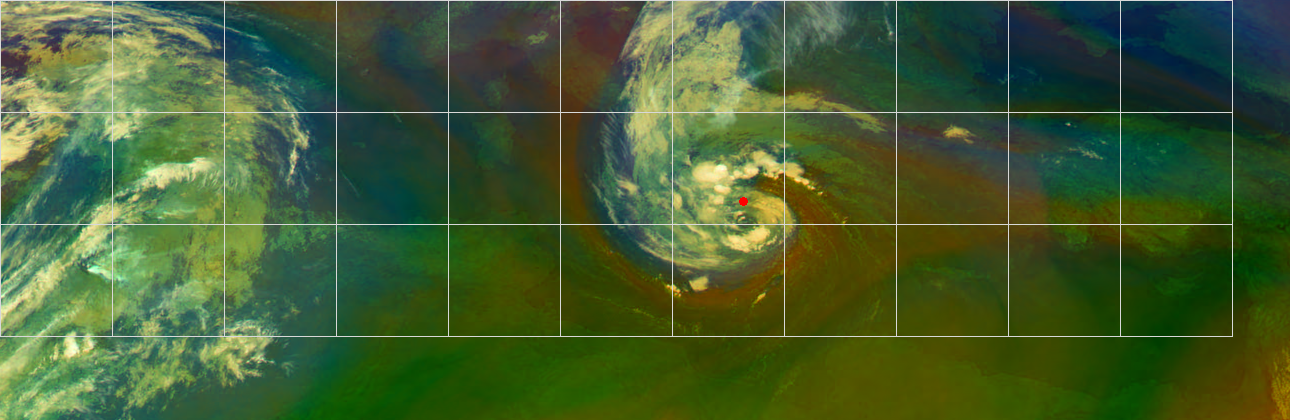

In [16]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
default_offsets = calc_tile_offsets()
out_img = draw_tiles_and_center(
    pil_image=img_ianos,
    cyclone_centers=[center_px],
    default_offsets=default_offsets
)
display(out_img)

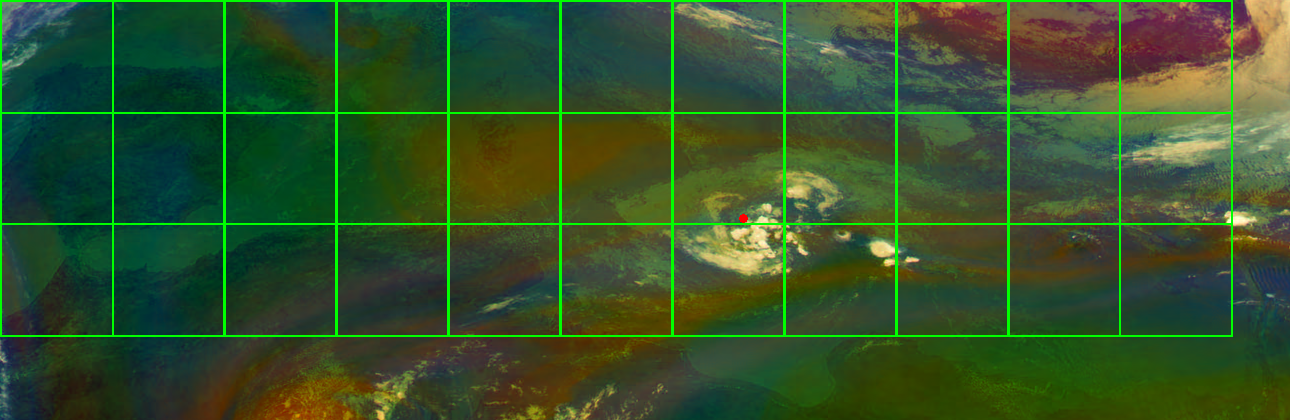

In [ ]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
out_img = draw_tiles_and_center(
    pil_image=img_trixie,
    cyclone_center=center_px
)
display(out_img)

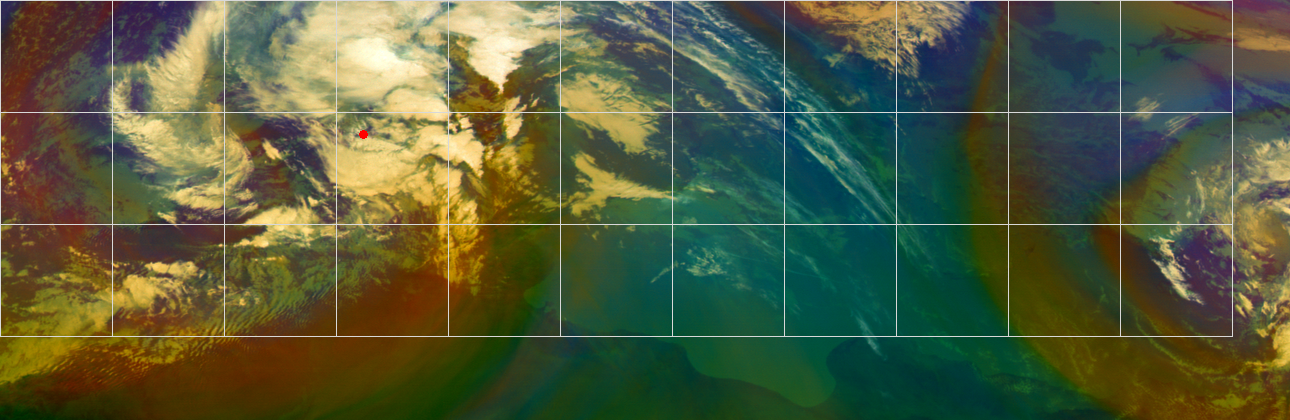

In [ ]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
out_img = draw_tiles_and_center(
    pil_image=img_rolf,
    cyclone_center=center_px
)
display(out_img)

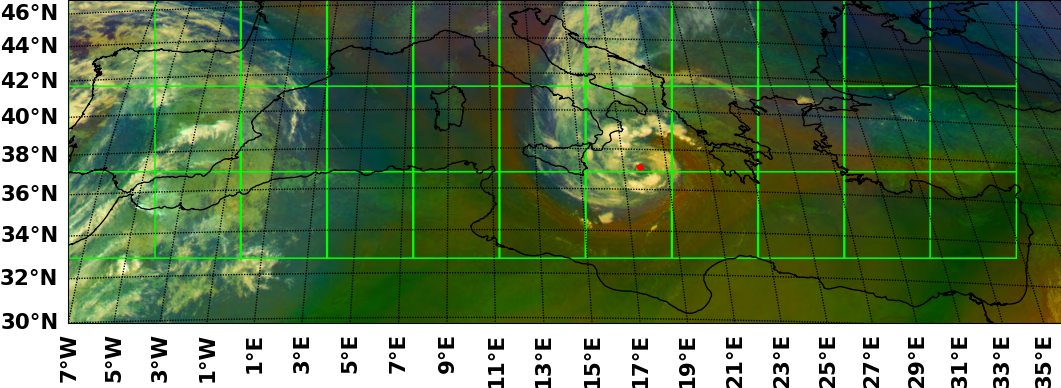

In [ ]:
plot_image(out_img, basemap_obj, draw_parallels_meridians=True)

### Etichettatura tiles

In [ ]:
lat, lon = df_candidates[['lat', 'lon']].values[0]
lat,lon

(37.069, 17.782)

In [ ]:
out_img = draw_tiles_and_center(
    pil_image=img,
    cyclone_center=center_px,
    labeled_tiles_offsets=labeled_tiles_offsets
)

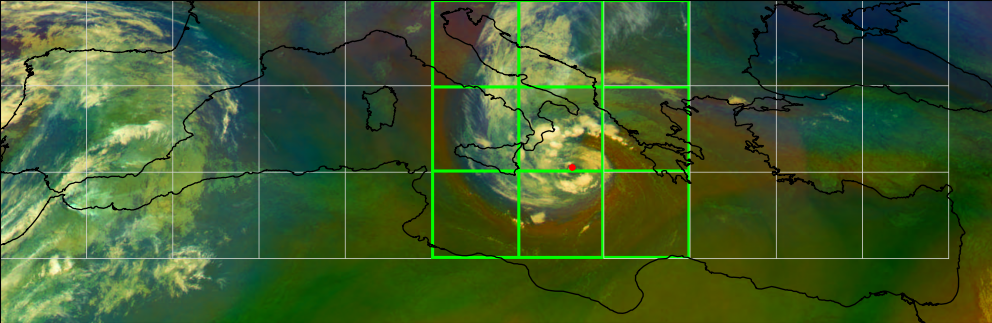

In [ ]:
plot_image(out_img, basemap_obj, draw_parallels_meridians=False)

# Etichettatura dataset

In [ ]:
from medicane_utils.load_files import load_all_images, get_all_cyclones

In [3]:
tracks_df = get_all_cyclones()
sorted_metadata_files = load_all_images(input_dir = "../fromgcloud")

Available Medicanes for training: ['Rolf' 'Ilona' 'Qendresa' 'Trixie' 'Numa' 'Zorbas' 'Ianos']
117764 files loaded.


In [4]:
tracks_df['Medicane'].unique()

array([None, 'Rolf', 'Ilona', 'Qendresa', 'Trixie', 'Numa', 'Zorbas',
       'Ianos'], dtype=object)

In [ ]:
df_data = labeled_tiles_from_metadatafiles(sorted_metadata_files, tracks_df)
df_data.shape

In [2]:
df_data = pd.read_csv("all_data.csv", dtype={
        "path": 'string',
        "tile_offset_x": 'int16',
        "tile_offset_y": 'int16',
        "label": 'category',
        "lat": 'float32',
        "lon": 'float32',
        "x_pix": 'Int16',
        "y_pix": 'Int16',
        "name": 'string'
    }, parse_dates=['datetime'])

In [4]:
#df_data.dtypes
df_data

Unnamed: 0                                         path   datetime  \
0                 0  ../fromgcloud/airmass_rgb_20111101_0000.png 2011-11-01   
1                 1  ../fromgcloud/airmass_rgb_20111101_0000.png 2011-11-01   
2                 2  ../fromgcloud/airmass_rgb_20111101_0000.png 2011-11-01   
3                 3  ../fromgcloud/airmass_rgb_20111101_0000.png 2011-11-01   
4                 4  ../fromgcloud/airmass_rgb_20111101_0000.png 2011-11-01   
...             ...                                          ...        ...   
2355275     2355275  ../fromgcloud/airmass_rgb_20230912_0000.png 2023-09-12   
2355276     2355276  ../fromgcloud/airmass_rgb_20230912_0000.png 2023-09-12   
2355277     2355277  ../fromgcloud/airmass_rgb_20230912_0000.png 2023-09-12   
2355278     2355278  ../fromgcloud/airmass_rgb_20230912_0000.png 2023-09-12   
2355279     2355279  ../fromgcloud/airmass_rgb_20230912_0000.png 2023-09-12   

         tile_offset_x  tile_offset_y label  lat  lon  x_pix  y_pix name  
0                    0              0     0  NaN  NaN   <NA>   <NA>   []  
1                  112              0     0  NaN  NaN   <NA>   <NA>   []  
2                  224              0     0  NaN  NaN   <NA>   <NA>   []  
3                  336              0     0  NaN  NaN   <NA>   <NA>   []  
4                  448              0     0  NaN  NaN   <NA>   <NA>   []  
...                ...            ...   ...  ...  ...    ...    ...  ...  
2355275            560            112     0  NaN  NaN   <NA>   <NA>   []  
2355276            672            112     0  NaN  NaN   <NA>   <NA>   []  
2355277            784            112     0  NaN  NaN   <NA>   <NA>   []  
2355278            896            112     0  NaN  NaN   <NA>   <NA>   []  
2355279           1008            112     0  NaN  NaN   <NA>   <NA>   []  

[2355280 rows x 11 columns]

In [4]:
mask_rolf = df_data['name'] == 'Rolf'
df_data_rolf = df_data[mask_rolf]

mask_ilona = df_data['name'] == 'Ilona'
df_data_ilona = df_data[mask_ilona]

mask_qendresa = df_data['name'] == 'Qendresa'
df_data_qendresa = df_data[mask_qendresa]

mask_trixie = df_data['name'] == 'Trixie'
df_data_trixie = df_data[mask_trixie]

mask_numa = df_data['name'] == 'Numa'
df_data_numa = df_data[mask_numa]

mask_ianos = df_data['name'] == 'Ianos'
df_data_ianos = df_data[mask_ianos]

In [6]:
len(df_data_rolf), len(df_data_ilona), len(df_data_qendresa), len(df_data_trixie), len(df_data_numa), len(df_data_ianos), 

(25440, 0, 32880, 31920, 28080, 39120)

In [7]:
def sub_select_group_df(df):
    df['dt_floor'] = df['datetime'].dt.floor('H')
    mask = df['datetime'] == df['dt_floor']
    df_filtered = df[mask]
    grouped = df_filtered.groupby("path", dropna=False)
    return grouped
    

In [8]:
g_rolf = sub_select_group_df(df_data_rolf)
g_qendresa = sub_select_group_df(df_data_qendresa)
g_trixie = sub_select_group_df(df_data_trixie)
g_numa = sub_select_group_df(df_data_numa)
g_ianos = sub_select_group_df(df_data_ianos)

####### Creiamo un raggruppamento per singola immagine
grouped = df_data_filtered.groupby("path", dropna=False)
img, g = list(grouped)[0]
####### per rolf
img, g = list(g_rolf)[1]
center_px_list = g[['x_pix','y_pix']].value_counts().index.values
#g['label'].values
g['datetime'].unique()[0]

In [12]:
def create_labeled_images_with_tiles(df_grouped, nome_gif):
# in ogni group abbiamo una sola immagine (un istante temporale)
# e tutte le tiles con le rispettive label. 
# possiamo avere più cicloni con le rispettive coordinate, da trovare uniche, perché si ripetono in tutte le tiles vicine
    lista_immagini = []
    for path_img, group_df in df_grouped:
        # Apriamo l'immagine
        img = Image.open(path_img)#.convert("RGB")
        #center_px_list = (x_pix, y_pix)
        center_px_list = group_df[['x_pix','y_pix']].value_counts().index.values
        #labeled_tiles_offsets = get_tile_labels(lat, lon)
        labeled_tiles_offsets = group_df['label'].values

        date_str = group_df['datetime'].unique()[0].strftime(" %H:%M %d-%m-%Y")
        
        # Disegniamo
        default_offsets = calc_tile_offsets()
        out_img = draw_tiles_and_center(img, default_offsets,
            cyclone_centers=center_px_list,
            labeled_tiles_offsets=labeled_tiles_offsets
            )
        stamped_img = draw_timestamp_in_bottom_right(out_img, date_str, margin=15)
        pi_img = plot_image(stamped_img, basemap_obj, latcorners, loncorners, draw_parallels_meridians=True)
        lista_immagini.append(pi_img)
        #display(out_img)
    
    lista_immagini[0].save(nome_gif, save_all=True, append_images=lista_immagini[1:], duration=200, loop=0)


### creiamo tutti i cicloni

In [13]:
create_labeled_images_with_tiles(g_rolf, 'rolf.gif')

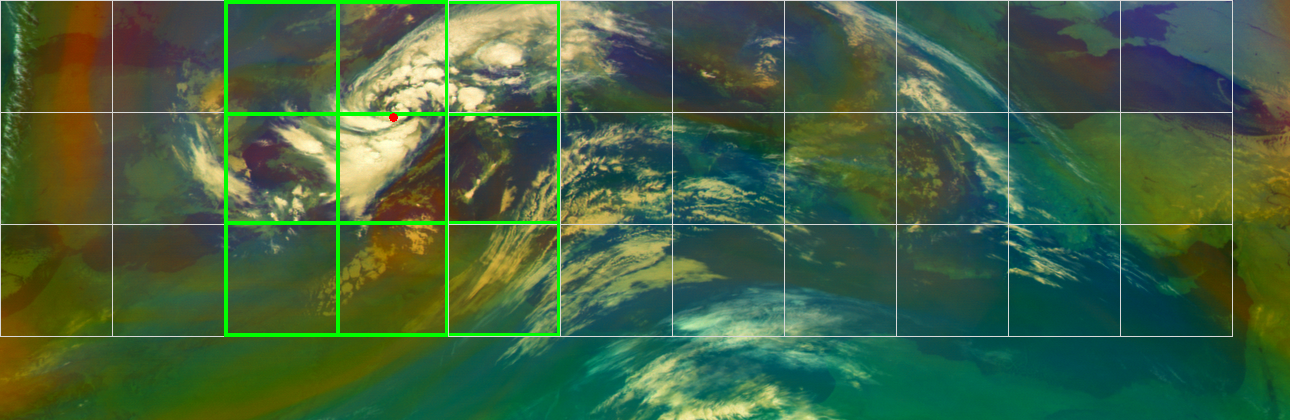

In [14]:
create_labeled_images_with_tiles(g_qendresa, 'qendresa.gif')

In [15]:
create_labeled_images_with_tiles(g_trixie, 'trixie.gif')

In [16]:
create_labeled_images_with_tiles(g_numa, 'numa.gif')

In [17]:
create_labeled_images_with_tiles(g_ianos, 'ianos.gif')

In [ ]:
# testare per un ciclone e un medicane
# accuracy sul training test